# Psience Examples

This is a hopefully growing set of examples of what can be done with Psience. The examples will mostly be self-contained(?) and might include some degree of exploration/development ideas. At a minimum, they should complement the unit tests to provide a starting point for working with the libraries.

## Configure Examples Environment

In [1]:
import sys
import os
import importlib
import numpy as np
import scipy
import json
np.set_printoptions(linewidth=1e8, suppress=True)

import McUtils.Plots as plt
from McUtils.Data import UnitsData
import McUtils.Numputils as nput
from Psience.Molecools import Molecule

import Psience
class TestManager:
    projects_dir = os.path.expanduser("~/Documents/Postdoc/Projects/")
    test_dir = os.path.join(os.path.dirname(Psience.__file__), "ci", "tests", "TestData")
    @classmethod
    def test_data(cls, filename):
        return os.path.join(cls.test_dir, filename)
    @classmethod
    def project_data(cls, filename):
        return os.path.join(cls.projects_dir, filename)
    
    @classmethod
    def load_module(cls, module):
        if module in sys.modules:
            from McUtils.Jupyter import ModuleReloader
            ModuleReloader(module).reload()
        return importlib.import_module(module)
    @classmethod
    def import_from(cls, module, names, set_glob=True):
        mod = cls.load_module(module)
        objs = []
        single = isinstance(names, str)
        if single: names = [names]
        for name in names:
            obj = getattr(mod, name)
            if set_glob:
                globals()[name] = obj
            objs.append(obj)
        if single: objs = objs[0]
        return objs

def parse_x3d_view_matrix(vs, view_all=True):
    #vs from JSON.stringify(document.getElementById('x3d').runtime.viewMatrix())
    vm = json.loads(vs)
    vm = np.linalg.inv([
        [vm[f"_{i}{j}"] for j in range(4)]
        for i in range(4)
    ])
    ang, ax = nput.extract_rotation_angle_axis(vm[:3, :3])
    v_pos = vm[:3, -1].tolist()
    v_ort = np.array(list(ax) + [ang]).tolist()
    opts = {"position":v_pos, "orientation":v_ort}
    if view_all:
        opts['viewAll'] = True
    return opts

### Edge Graph Tests

In [153]:
import numpy as np
import collections
import scipy.sparse as sparse
import McUtils.Numputils as nput

In [206]:
Molecule = TestManager.import_from("Psience.Molecools", "Molecule")
ooc = Molecule.from_string("O-O-C", "smi", add_implicit_hydrogens=True)

In [211]:
ooc.plot(highlight_atoms=[0, 1, 2, 4, 5, 6], return_objects=False)

In [215]:
np.asarray(ooc.coords[(0, 1, 2),])

array([[ 2.74615707, -1.04527076,  0.30898777],
       [ 0.50300851, -1.7121612 , -0.46351693],
       [-1.30781376,  0.14872769, -0.00120321]])

In [220]:
nput = TestManager.load_module("McUtils.Numputils")
n = 2
# rand_coords = np.random.rand(4 + n, 3)
rand_coords = np.asarray(ooc.coords[(0, 1, 2, 4, 5, 6),])
Y = 0 + n
X1 = 1 + n
X2 = 2 + n
X3 = 3 + n
R1 = n - 1
R2 = n - 2
R3 = n - 3
d_rand = nput.internal_coordinate_tensors(
    rand_coords,
    [
        [Y, X1],
        [Y, X2],
        [Y, X3],
        [X1, Y, X2],
        [X1, Y, X3],
        [X2, Y, X3],
        [R1, Y],
        [X1, Y, R1, X2],
        [X2, Y, R1, X3],
        [X3, Y, R1, X1],
        [R2, R1],
        [R2, R1, Y],
        [R3, R2],
        [R3, R2, R1]
        # [0, 1, Y],
    ],
    angle_ordering="ijk",
)
d_rand.shape, np.linalg.eigvalsh(d_rand.T @ d_rand)

((18, 14),
 array([-0.        , -0.        ,  0.03124727,  0.07272811,  0.16004023,  0.53344948,  1.04275037,  1.11075687,  1.19983041,  1.69982972,  2.34011662,  3.08884352,  5.09997234,  5.16915689]))

In [158]:
h2o = EdgeGraph(["O", "H", "H"], [[0, 1], [0, 2]])
ohh = EdgeGraph(["O", "H", "H"], [[0, 1], [1, 2]])

In [160]:
aaaa = EdgeGraph(anion_nitro.atoms, anion_nitro.bonds)

In [167]:
perm = np.pad(1 + np.argsort(np.random.randint(0, 1000, len(anion_nitro.atoms) - 1)), [1, 0])
inv = np.argsort(perm)
perm_nitro = Molecule(
    [anion_nitro.atoms[a] for a in perm], 
    anion_nitro.coords[perm,],
    bonds=[[inv[i], inv[j]] for i,j in anion_nitro.bonds]
)
bbbb = EdgeGraph(perm_nitro.atoms, perm_nitro.bonds)

In [168]:
EdgeGraph.graph_match(aaaa, bbbb)

True

## TestPlots

In [ ]:
from McUtils.Jupyter import ModuleReloader
ModuleReloader("McUtils.Plots").reload()
ModuleReloader("McUtils.Jupyter").reload()
import McUtils.Plots as plt

In [ ]:
grids = [
    np.meshgrid(
        np.linspace(r, r+2*np.pi, 250),
        np.linspace(-r, -r+2*np.pi, 250),
        indexing='ij'
    )
    for r in np.linspace(0, np.pi, 10)
]
frame_data = [
    np.cos(g[0]) * np.sin(g[1])
    for g in grids
]


fig = plt.ArrayPlot(frame_data[0], frame=[[None, None], [None, None]])
frames = [
    plt.ArrayPlot(frame, figure=fig)
    for frame in frame_data[1:]
]
fig.animate_frames(frames)

In [ ]:
from McUtils.Jupyter import X3DHTML, JHTML

JHTML.Figure(
    JHTML.Script(src='http://www.x3dom.org/download/x3dom.js'),
    JHTML.Link(rel='stylesheet', href='http://www.x3dom.org/download/x3dom.css'),
    X3DHTML.X3D(
        X3DHTML.Scene(
            JHTML.Input(type="range", value="0", min="0", max="1", step="1", cls="slider",
                        oninput="""document.getElementById("animation-frames").setAttribute("whichChoice", this.value)"""),
            X3DHTML.Switch(
                X3DHTML.Shape(
                    X3DHTML.Appearance(X3DHTML.Material(diffuseColor='red')),
                    X3DHTML.Sphere()
                ),
                X3DHTML.Shape(
                    X3DHTML.Appearance(X3DHTML.Material(diffuseColor='blue')),
                    X3DHTML.Sphere()
                ),
                whichChoice="0",
                id="animation-frames"
            )
            
        )
    ),
    width='500px',
    height='500px'
)

## VPT

In [2]:
from Psience.VPT2 import *

### test_HOHAnalytic

In [5]:
file_name = "HOH_freq.fchk"
runner, states = AnalyticVPTRunner.construct(
    TestManager.test_data(file_name),
    [[
        0,
        [[0, 0, 1]]
    ]],
    # expressions_file=os.path.expanduser("~/Desktop/exprs.hdf5")
)
classic, _ = runner.construct_classic_runner(states)
mat_wfns = classic.print_tables()
atp_corrs = runner.run_VPT(states)

>>------------------------- calculating G-matrix derivatives -------------------------
:: took 0.000s...
>>--------------------------------------------------<<
>>------------------------- calculating potential derivatives -------------------------
:: prepping grad...
:: Cartesian transformation...
:: handling mixed derivative symmetry (MixedDerivativeHandlingModes.Analytical)...
:: checking Hessian...
:: took 0.015s...
>>--------------------------------------------------<<
>>------------------------- calculating dipole derivatives -------------------------
:: took 0.008s
>>--------------------------------------------------<<
>>------------------------- Computing PT corrections: -------------------------
:: states: 2
:: order: 2
:: expansion order: 2
::> getting representations
  > trying to load from checkpoint...
  > failed to load, building instead...
  ::> getting basis
    > trying to load from checkpoint...
    > fail to load, building instead...
    > getting states for H(1)|n(0)

### test_AnalyticWFC

In [6]:
file_name = "OCHH_freq.fchk"
AnalyticVPTRunner.run_simple(
    TestManager.test_data(file_name),
    [
        [
            0,
            [
                [0, 0, 0, 0, 0, 1],
                [0, 1, 0, 1, 0, 0],
                [0, 0, 0, 1, 1, 0],
                [0, 0, 0, 0, 1, 0],
            ],
        ],
        [
            [0, 0, 0, 0, 1, 0],
            [
                [0, 0, 0, 0, 1, 1],
                [0, 1, 0, 1, 1, 0]
            ]
        ]
    ],
    degeneracy_specs='auto',
    handle_degeneracies=True
)

>>------------------------- calculating G-matrix derivatives -------------------------
:: took 0.000s...
>>--------------------------------------------------<<
>>------------------------- calculating potential derivatives -------------------------
:: prepping grad...
:: Cartesian transformation...
:: handling mixed derivative symmetry (MixedDerivativeHandlingModes.Analytical)...
:: checking Hessian...
:: took 0.019s...
>>--------------------------------------------------<<
>>------------------------- calculating dipole derivatives -------------------------
:: took 0.013s
>>--------------------------------------------------<<
>>------------------------- Getting corrections at order 0 -------------------------
::> Building evaluator W[0][()]
  > took 0.000s
<::
::> evaluating...
  > took 0.000s
<::
>>--------------------------------------------------<<
>>------------------------- Getting corrections at order 0 -------------------------
::> Building evaluator W[0][(1, -1)]
  > took 0.000s

AnalyticPerturbationTheoryCorrections(states=BasisStateSpace(nstates=7, basis=HOBasis(dim=6)), state_lists=[[[[0, 0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0, 1], [0, 1, 0, 1, 0, 0], [0, 0, 0, 1, 1, 0], [0, 0, 0, 0, 1, 0]]], [[[0, 0, 0, 0, 1, 0]], [[0, 0, 0, 0, 1, 1], [0, 1, 0, 1, 1, 0]]]], _energies=array([0.02636274, 0.03934586, 0.03921411, 0.05172128, 0.04691512, 0.0398846 , 0.05255284]), _transition_moments=[[array([[ 0.        ,  0.        ,  0.        , -0.00000002]]), array([[0., 0.]])], [array([[-0.03782846, -0.0306695 , -0.        , -0.00000201]]), array([[-0.05043127, -0.01788934]])], [array([[ 0.00000247, -0.000002  ,  0.00498506, -0.0375401 ]]), array([[-0.00000037, -0.00000344]])]], _spectra=[[<Psience.Psience.Spectra.BaseSpectrum.DiscreteSpectrum object at 0x7fef252d5a00>], [<Psience.Psience.Spectra.BaseSpectrum.DiscreteSpectrum object at 0x7fef252fc550>]], _deperturbed_energies=array([0.02636274, 0.03956124, 0.03921411, 0.05181577, 0.04691512, 0.03966922, 0.05245835]), _deperturbed

### test_OCHHMultiple

Run starting from multiple initial states with automatic degeneracy handling

In [7]:
file_name = "OCHH_freq.fchk"
runner, states = AnalyticVPTRunner.construct(
    TestManager.test_data(file_name),
    [
        [
            0,
            [
                [0, 0, 0, 0, 0, 1],
                [0, 0, 0, 0, 1, 0],
                [0, 0, 0, 2, 0, 0]
            ],
        ],
        [
            [
                [0, 0, 0, 0, 0, 1],
            ],
            [
                [0, 0, 0, 0, 1, 0],
                [0, 0, 0, 2, 0, 0]
            ],
        ]
    ],
    degeneracy_specs='auto'
    # degeneracy_specs=[
    #             [[0, 0, 0, 0, 0, 1], [0, 1, 0, 1, 0, 0]]
    #         ],
    # degeneracy_specs={
    #     'polyads': [
    #         [
    #             [0, 0, 0, 0, 0, 1],
    #             [0, 0, 0, 0, 1, 0]
    #         ],
    #         [
    #             [0, 0, 0, 0, 0, 1],
    #             [0, 1, 0, 1, 0, 0]
    #         ]
    #     ]
    # }
)
classic, _ = runner.construct_classic_runner(states,
                                             zero_element_warning=False
                                             )
classic.print_tables()
runner.run_VPT(states)

>>------------------------- calculating G-matrix derivatives -------------------------
:: took 0.000s...
>>--------------------------------------------------<<
>>------------------------- calculating potential derivatives -------------------------
:: prepping grad...
:: Cartesian transformation...
:: handling mixed derivative symmetry (MixedDerivativeHandlingModes.Analytical)...
:: checking Hessian...
:: took 0.018s...
>>--------------------------------------------------<<
>>------------------------- calculating dipole derivatives -------------------------
:: took 0.013s
>>--------------------------------------------------<<
>>------------------------- Getting corrections at order 0 -------------------------
>>------------------------- Building evaluator W[0][()] -------------------------
:: took 0.000s
>>--------------------------------------------------<<
::> evaluating...
  > took 0.000s
<::
>>--------------------------------------------------<<
>>------------------------- Getting c

AnalyticPerturbationTheoryCorrections(states=BasisStateSpace(nstates=5, basis=HOBasis(dim=6)), state_lists=[[[[0, 0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 0], [0, 0, 0, 2, 0, 0], [0, 1, 0, 1, 0, 0]]], [[[0, 0, 0, 0, 0, 1], [0, 1, 0, 1, 0, 0]], [[0, 0, 0, 0, 1, 0], [0, 0, 0, 2, 0, 0]]]], _energies=array([0.02636274, 0.03934586, 0.03921411, 0.04172755, 0.0398846 ]), _transition_moments=[[array([[ 0.        , -0.00000002, -0.        ,  0.        ]]), array([[-0.,  0.],
       [ 0.,  0.]])], [array([[-0.03782846, -0.00000201,  0.        , -0.0306695 ]]), array([[-0.01743934, -0.00333539],
       [-0.01342639, -0.00059361]])], [array([[ 0.00000247, -0.0375401 , -0.01037231, -0.000002  ]]), array([[ 0.00000104, -0.00000004],
       [-0.00000127,  0.00000004]])]], _spectra=[[<Psience.Psience.Spectra.BaseSpectrum.DiscreteSpectrum object at 0x7fef24604bb0>], [<Psience.Psience.Spectra.BaseSpectrum.DiscreteSpectrum object at 0x7fef25ef5790>, <Psience.Psience.Spectra.BaseSpectrum.Disc

## Molecular Visualization

### Load NH3

In [ ]:
TestManager.import_from("Psience.Molecools", "Molecule")

nh3 = Molecule.from_file(
    TestManager.test_data("nh3.fchk"),
    internals=[
        [0, -1, -1, -1],
        [1,  0, -1, -1],
        [2,  0,  1, -1],
        [3,  0,  1,  2]
    ],
    bonds=[
        [0, 1],
        [0, 2],
        [0, 3]
    ]
)
nh3

### Animate Dihedral

#### Simplified

It's so common to want to animate a given coordinate that I just added in a bespoke function for it...

In [ ]:
# I extracted a nice default viewmatrix from the X3D HTML element
vs = "{\"_00\":-0.9998172405453938,\"_01\":0.018742171764957148,\"_02\":-0.0037704781839175533,\"_03\":1.4745149545802857e-17,\"_10\":-0.003051418775696821,\"_11\":-0.35114503482210363,\"_12\":-0.9363161076064184,\"_13\":1.8034076836037622e-15,\"_20\":-0.01887258200824471,\"_21\":-0.9361334816773265,\"_22\":0.35113804996187,\"_23\":-5.482585044070595,\"_30\":0,\"_31\":0,\"_32\":0,\"_33\":0.9999999999999998}"
viewpoint = parse_x3d_view_matrix(vs)

nh3.animate_coordinate(5, view_settings=viewpoint)

#### Better Control

In [ ]:
coord_expansion = nh3.get_cartesians_by_internals(2, strip_embedding=True)

geoms = nh3.get_scan_coordinates(
    [[-.3, .3, 10]],
    which=[5],
    coordinate_expansion=coord_expansion
)
geoms = np.concatenate([geoms, np.flip(geoms, axis=0)], axis=0)

# I extracted a nice default viewmatrix from the X3D HTML element
vs = "{\"_00\":-0.9998172405453938,\"_01\":0.018742171764957148,\"_02\":-0.0037704781839175533,\"_03\":1.4745149545802857e-17,\"_10\":-0.003051418775696821,\"_11\":-0.35114503482210363,\"_12\":-0.9363161076064184,\"_13\":1.8034076836037622e-15,\"_20\":-0.01887258200824471,\"_21\":-0.9361334816773265,\"_22\":0.35113804996187,\"_23\":-5.482585044070595,\"_30\":0,\"_31\":0,\"_32\":0,\"_33\":0.9999999999999998}"
viewpoint = parse_x3d_view_matrix(vs)

nh3.plot(geoms, view_settings=viewpoint, return_objects=False)

## Molecule Formats

In [89]:
from McUtils.Data import UnitsData

In [142]:
TestManager.load_module("McUtils.ExternalPrograms")
TestManager.import_from("Psience.Molecools", "Molecule")

ccc = Molecule.from_string("CCC", "smi", 
                           add_implicit_hydrogens=True, 
                           internals=[b[:2] for b in ccc.bonds]
                          )
# ccc.animate_coordinate(5)

In [143]:
ccc.g_matrix

[array([[ 0.00009143, -0.00001367, -0.00001562, -0.00001715, -0.00001562, -0.00001496, -0.00001589,  0.        ,  0.        ,  0.        ],
        [-0.00001367,  0.00009143,  0.        ,  0.        ,  0.        , -0.00001749, -0.00001665, -0.00001835, -0.00001491, -0.00001431],
        [-0.00001562,  0.        ,  0.00059004, -0.00001187, -0.000019  ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [-0.00001715,  0.        , -0.00001187,  0.00059004, -0.00001191,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [-0.00001562,  0.        , -0.000019  , -0.00001191,  0.00059004,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [-0.00001496, -0.00001749,  0.        ,  0.        ,  0.        ,  0.00059004, -0.00001272,  0.        ,  0.        ,  0.        ],
        [-0.00001589, -0.00001665,  0.        ,  0.        ,  0.        , -0.00001272,  0.00059004,  0.        ,  0.        ,  0.        ],
        [ 0.        

In [4]:
TestManager.load_module("McUtils.ExternalPrograms")
TestManager.import_from("Psience.Modes", "EdgeGraph")

mol = Molecule.from_file(
    TestManager.project_data("2DIR/freq_anion_12_11.fchk")
)
mol.bonds = mol.rdmol.bonds
mol.rdmol.rings

((12, 2, 0, 8, 15), (18, 8, 0, 9, 21), (24, 9, 0, 3, 27), (2, 1, 0), (3, 1, 0))

In [69]:
vm = parse_x3d_view_matrix("{\"_00\":-0.18544862833983825,\"_01\":0.9334430170087512,\"_02\":-0.30707155557698484,\"_03\":-0.1930534715181078,\"_10\":0.8384947084198391,\"_11\":-0.012623886972170956,\"_12\":-0.544763491278227,\"_13\":0.9682956575401015,\"_20\":-0.5123821134649438,\"_21\":-0.3585035166847202,\"_22\":-0.7803459478499788,\"_23\":-32.75498005772947,\"_30\":0,\"_31\":0,\"_32\":0,\"_33\":0.9999999999999944}")

In [73]:
vm

{'position': [-17.63077819500415, -11.550347469799654, -25.092005066773886],
 'orientation': [-0.6356574254425159,
  -0.7006721703256035,
  0.3240341759922875,
  2.9945536707471234],
 'viewAll': True}

In [ ]:
mol.plot(
    highlight_atoms=[25],
    view_settings=vm,
    return_objects=False
)

In [118]:
TestManager.load_module("McUtils.Numputils")
Molecule = TestManager.import_from("Psience.Molecools", "Molecule")

# ccc = Molecule.from_string("CCC", "smi", add_implicit_hydrogens=True, internals={'primitives':'auto', 'nonredundant_coordinates':[(0, 1)]})
# ccc_atoms = ccc.atoms
# ccc_coords = ccc.coords
ccc = Molecule(ccc_atoms, ccc_coords, 
               internals={
                   'primitives':'auto', 
                   'nonredundant_coordinates':[(0, 1)], 
                   # 'base_coords':[
                   #     (6, 1, 0, 2), (7, 1, 0, 2),
                   #     (6, 1, 2, 0), (7, 1, 2, 0)
                   # ]
               }
              )
# red_tf = ccc.internal_coordinates.converter_options['redundant_transformation']
# [
#     set(ccc.internals['specs']) - set(ccc_zm_coords) - set(tuple(reversed(c)) for c in ccc_zm_coords),
#     set(ccc_zm_coords) - set(ccc.internals['specs']) - set(tuple(reversed(c)) for c in ccc.internals['specs'])
# ]
# ccc.internals['specs']

In [95]:
methane = Molecule.from_string("C", "smi", add_implicit_hydrogens=True, 
                     internals={'primitives':[
                         (0,1),
                         (0,2),
                         (0,3),
                         (0,4),
                         (1, 0, 2),
                         (1, 0, 3),
                         (1, 0, 4),
                         (2, 0, 3),
                         (2, 0, 4),
                         (3, 0, 4)
                     ]})

In [96]:
methane.internal_coordinates.converter_options['redundant_transformation'].shape

(10, 9)

In [91]:
red_tf = ccc.internal_coordinates.converter_options['redundant_transformation']

In [ ]:
ccc.animate_coordinate(2)

In [109]:
set(ccc.internals['specs']) - set(ccc_zm_coords) - set(tuple(reversed(c)) for c in ccc_zm_coords)

{(2, 1, 6),
 (2, 1, 7),
 (3, 0, 1, 6),
 (3, 0, 1, 7),
 (3, 0, 4),
 (3, 0, 5),
 (4, 0, 1, 6),
 (4, 0, 1, 7),
 (4, 0, 5),
 (5, 0, 1, 6),
 (5, 0, 1, 7),
 (6, 1, 2, 8),
 (6, 1, 2, 9),
 (6, 1, 2, 10),
 (6, 1, 7),
 (7, 1, 2, 8),
 (7, 1, 2, 9),
 (7, 1, 2, 10),
 (8, 2, 9),
 (8, 2, 10),
 (9, 2, 10)}

In [110]:
set(ccc_zm_coords) - set(ccc.internals['specs']) - set(tuple(reversed(c)) for c in ccc.internals['specs'])

{(6, 1, 0, 2), (7, 1, 0, 2)}

In [ ]:
ccc_zm_coords = [
            (0, 1),
            (0, 1, 2),
            (1, 2),
            (10, 2),
            (10, 2, 1),
            (3, 0),
            (3, 0, 1),
            (3, 0, 1, 2),
            (4, 0),
            (4, 0, 1),
            (4, 0, 1, 2),
            (5, 0),
            (5, 0, 1),
            (5, 0, 1, 2),
            (6, 1),
            (6, 1, 0),
            (6, 1, 0, 2),
            (7, 1),
            (7, 1, 0),
            (7, 1, 0, 2),
            (8, 2),
            (8, 2, 1),
            (8, 2, 1, 0),
            (9, 2),
            (9, 2, 1),
            (9, 2, 1, 0),
            (10, 2, 1, 0),
    ]

In [120]:
ccc_3 = Molecule(
    ccc_atoms,
    ccc_coords,
    internals={
        "primitives": ccc_zm_coords, 
        'base_coords':[(0, 1)]
    },
)  # {'specs':'auto', 'base_coords':[(0, 3)]})
# ccc.get_cartesians_by_internals(1)[0] @ ccc_3.get_internals_by_cartesians(1)[0]
# ccc_3.animate_coordinate(0)

In [274]:
ccc_2 = Molecule(ccc_atoms, ccc_coords, internals=[
    [0, -1, -1, -1],
    [1,  0, -1, -1],
    [2,  1,  0, -1],
    [3,  0,  1,  2],
    [4,  0,  1,  2],
    [5,  0,  1,  2],
    [6,  1,  0,  2],
    [7,  1,  0,  2],
    [8,  2,  1,  0],
    [9,  2,  1,  0],
    [10, 2,  1,  0],
])
ccc_2.get_internals_by_cartesians(1, strip_embedding=True)[0][:, 0]

array([ 0.86546744, -0.18885007, -0.46400615, -0.86546744,  0.18885007,  0.46400615,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [ ]:
ccc_3 = Molecule(
    ccc_atoms,
    ccc_coords,
    internals={
        "primitives": [
            (0, 1),
            (0, 1, 2),
            (1, 2),
            (10, 2),
            (10, 2, 1),
            (3, 0),
            (3, 0, 1),
            (3, 0, 1, 2),
            (4, 0),
            (4, 0, 1),
            (4, 0, 1, 2),
            (5, 0),
            (5, 0, 1),
            (5, 0, 1, 2),
            (6, 1),
            (6, 1, 0),
            (6, 1, 0, 2),
            (7, 1),
            (7, 1, 0),
            (7, 1, 0, 2),
            (8, 2),
            (8, 2, 1),
            (8, 2, 1, 0),
            (9, 2),
            (9, 2, 1),
            (9, 2, 1, 0),
            (10, 2, 1, 0),
        ],
        "nonredundant_coordinates": [(0, 1)],
    },
)  # {'specs':'auto', 'base_coords':[(0, 3)]})
ccc_3.animate_coordinate(0)

## Coordinate Utils

## Experimental Developments

In [3]:
import scipy.sparse as sparse

def build_coord_graph(natoms, bonds):
    adj = np.zeros((natoms, natoms), dtype=bool)
    bonds = np.asanyarray(bonds)
    rows = bonds[:, 0]; cols = bonds[:, 1]
    adj[rows, cols] = 1
    adj[cols, rows] = 1
    
    return sparse.csr_matrix(adj)
def _get_shortest_path(sp_data, i, j):
    lens, preds = sp_data
    n = int(lens[i, j])
    path = np.empty(n + 1, dtype=int)
    path[-1] = j
    k = j
    for c in range(1, n+1):
        prev = preds[i, k]
        path[-(c+1)] = prev
        k = prev
    # if preds[i, k] != j:
    #     raise ValueError(i, j, k)
    return path
def shortest_path_function(graph):
    lens, preds = sparse.csgraph.shortest_path(graph, return_predecessors=True, unweighted=True, directed=False)
    def shortest_path(i, j, data=(lens.astype('uint64'), preds)):
        return _get_shortest_path(data, i, j)
    return shortest_path
def find_rings(csgraph):
    return sparse.csgraph.shortest_path(csgraph, return_predecessors=True, unweighted=True, directed=False)
# def get_path(shortest_path_data, start, end):
    
adj_graph = build_coord_graph(len(anion_nitro.atoms), anion_nitro.bonds)
shorts = shortest_path_function(adj_graph)

In [892]:
Molecule = TestManager.import_from("Psience.Molecools", "Molecule")

anion_nitro = Molecule.from_file(
    os.path.expanduser("~/Documents/Postdoc/Projects/2DIR/freq_anion_12_11.fchk"),
    internals = {
        'primitives':'auto',
        'nonredundant_coordinates':[
            (4, 7),
            (5, 10),
            (6, 11),
            (4, 7, 0),
            (5, 10, 1),
            (6, 11, 1),
            (0, 7),
            (1, 10),
            (1, 11)
        ],
        'base_coords':[
            # (4, 7),
            # (5, 10),
            # (6, 11),
            # (4, 7, 0),
            # (5, 10, 1),
            # (6, 11, 1),
            # (0, 7),
            # (1, 10),
            # (1, 11),
            (0, 1),
            (0, 2),
            (0, 3),
            (1, 2),
            (1, 3),
            (2, 0, 1, 3)
        ],
        # 'prune_coordinates':False
    }
)
# plt.ArrayPlot(anion_nitro.internal_coordinates.converter_options['redundant_transformation'])

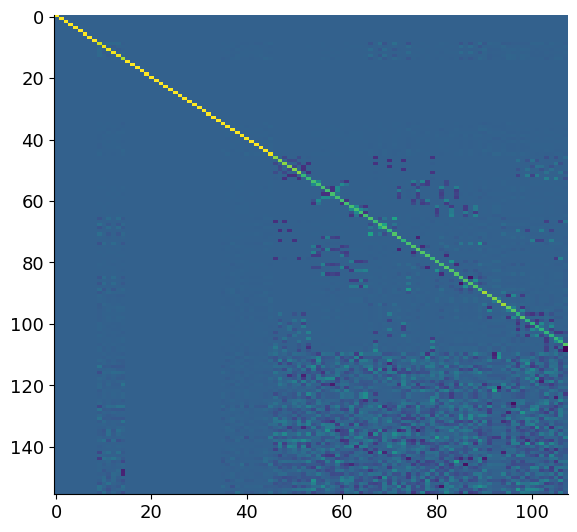

In [893]:
plt.ArrayPlot(anion_nitro.internal_coordinates.converter_options['redundant_transformation'])

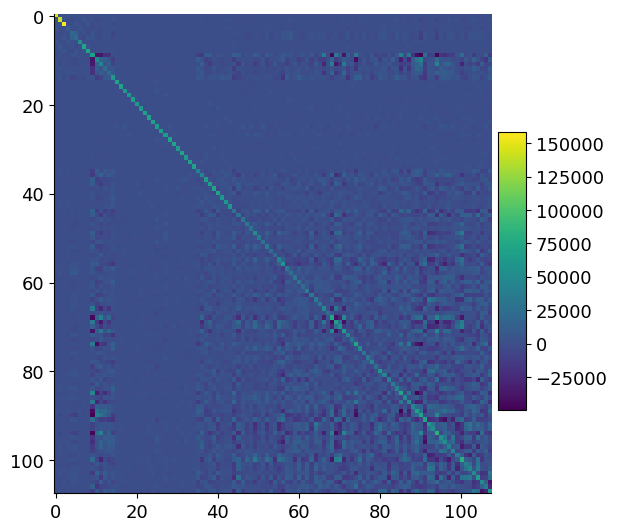

In [895]:
cart_conv = anion_nitro.get_cartesians_by_internals(2)
internal_tensors = nput.tensor_reexpand(cart_conv, [0, anion_nitro.potential_derivatives[1]])
plt.ArrayPlot(internal_tensors[1] * UnitsData.convert("Hartrees", "Wavenumbers"), colorbar=True)

In [654]:
from McUtils.Formatters import TableFormatter
print(
    TableFormatter(
    ".1f"
).format(
    internal_tensors[1][:3, 3:20] * UnitsData.convert("Hartrees", "Wavenumbers")
)
)

3367.5    372.9  -227.7  4084.2    18.0  -115.4  -206.0   670.9  756.7  796.3  910.8  -411.6  -592.6   -20.2   87.3  148.9  117.9
-291.8  -1762.1   387.5  -184.2  5675.4   934.5  1331.5  -898.9  -40.1  727.3  758.2  -231.8   262.6  1829.9  168.9   87.9  -95.3
-214.7    399.1  3136.0  -173.1   637.0  6240.3  -576.0   350.5  192.3  536.7  422.6   -36.8  -355.9  -712.0   67.7  128.8   36.3


In [665]:
from IPython.display import display, HTML
display(HTML("<style>div.jp-OutputArea-output pre {white-space: pre;}</style>"))

print(
    TableFormatter(".1f").format(
        np.abs(internal_tensors[1][:3, 9:]) * UnitsData.convert("Hartrees", "Wavenumbers")
    )
)

 206.0  670.9  756.7  796.3  910.8  411.6  592.6    20.2   87.3  148.9  117.9    2.0  121.6  187.7   17.3  190.5  161.1  114.9  165.6   67.4    0.9  156.5  171.0  118.6  181.8  197.8   158.2   62.2  103.6  303.8   314.4  765.8  515.3   104.9    3.5  220.0  504.0  526.5  413.9  191.2  196.9  1003.3   13.0  250.1  1320.1  257.0   56.5  149.9  580.5  780.8  278.9  349.6  125.0  403.5   16.1  641.6    77.6   693.5   321.3  519.5  121.5  190.3  269.0  275.0  224.9  121.9  168.6  206.1  103.7  46.0   23.1   69.7  130.8  276.4  779.2   10.9   202.0  261.9  235.5  161.3   67.9   67.6  238.2  124.0   67.1  168.8  290.6  39.5  249.8  233.5  214.4     4.7  222.8   806.9  266.7  22.4  100.7   50.5  137.4
1331.5  898.9   40.1  727.3  758.2  231.8  262.6  1829.9  168.9   87.9   95.3  412.7  120.3  196.5  487.9  187.6   73.5   41.5   22.7  245.9  483.0  199.2  155.1   77.1   17.1  372.0  1155.3  718.3  402.9  331.0  1268.0  169.9  955.3  1816.3  163.6  679.0  200.7  920.6  362.8  111.6  575.5    60.8

In [667]:
np.where(
    np.abs(internal_tensors[1][:3, 9:]) * UnitsData.convert("Hartrees", "Wavenumbers") > 1000
)

(array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([41, 44,  0,  7, 26, 30, 33, 56, 57, 58, 76, 91, 93]))

In [ ]:
anion_nitro.animate_coordinate(1)

In [ ]:
anion_nitro.animate_coordinate(9)

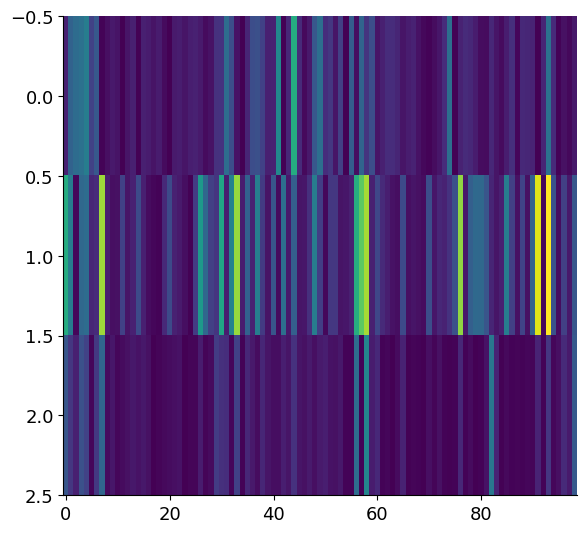

In [666]:
plt.ArrayPlot(np.abs(internal_tensors[1][:3, 9:]) * UnitsData.convert("Hartrees", "Wavenumbers"))

In [650]:
internal_tensors[1][:3, 3:] * UnitsData.convert("Hartrees", "Wavenumbers")

array([[ 3367.49004864,   372.90494656,  -227.73946145,  4084.1962599 ,    18.00289761,  -115.41115607,  -205.96376957,   670.94195626,   756.66451865,   796.33361822,   910.84703747,  -411.61013164,  -592.58917696,   -20.17523361,    87.344781  ,   148.94032383,   117.85843431,    -2.02214358,   121.5817262 ,   187.72957354,    17.29596547,   190.47909583,   161.10871016,   114.85391835,   165.6238068 ,    67.35369024,     0.90716494,   156.53816878,   170.97032735,   118.55772978,   181.83286978,  -197.76762435,   158.18381294,   -62.21198295,   103.56480907,  -303.77064476,  -314.36599442,  -765.75008269,  -515.34269441,  -104.87765772,     3.47216777,   219.97319723,  -503.98744436,  -526.54832646,   413.87162202,   191.20169642,  -196.92373628,  1003.32323174,   -12.95243568,   250.14759876, -1320.09162439,  -256.96778824,   -56.4552216 ,  -149.91701664,  -580.54070851,  -780.82024033,   278.89955953,  -349.59469495,  -124.98573021,  -403.50406303,    16.05163878,  -641.56613363, 

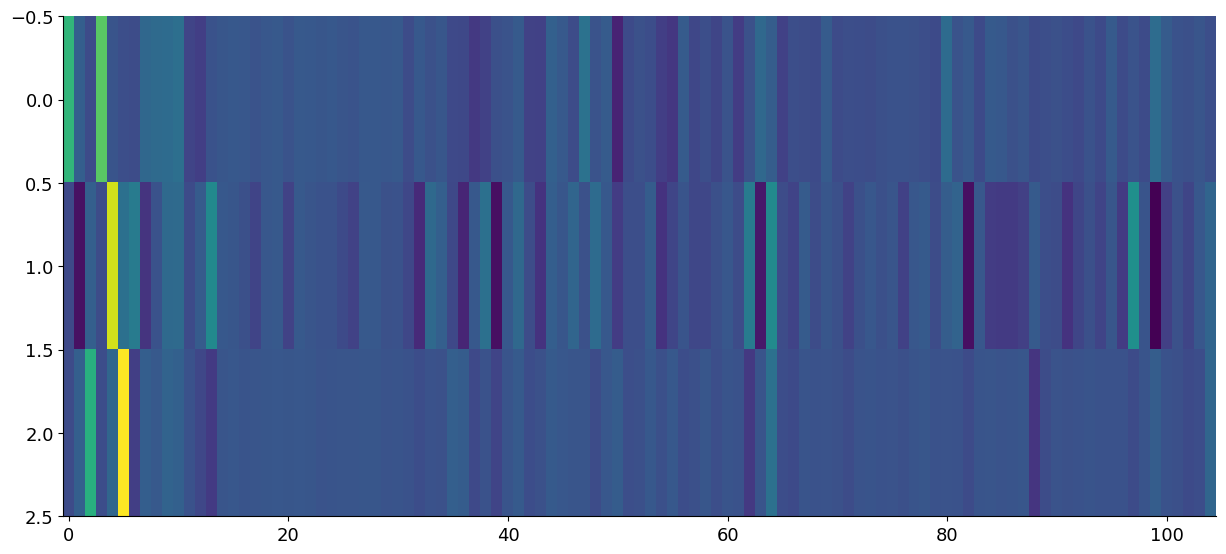

In [649]:
plt.ArrayPlot(internal_tensors[1][:3, 3:] * UnitsData.convert("Hartrees", "Wavenumbers"), image_size=(900, 50))

In [645]:
couplings = internal_tensors[1][:6, 6:] * UnitsData.convert("Hartrees", "Wavenumbers")

In [644]:
couplings[:6, :6]

array([[ -511.81559391,  4084.1962599 ,    18.00289761,  -115.41115607,   831.55323366,   952.06101277],
       [ 1286.60481131,  -184.19063313,  5675.38999634,   934.50853066,  -743.56699964,  -260.53613284],
       [ -565.38090755,  -173.08347263,   637.00449474,  6240.27541524,   332.0361526 ,   196.53005762],
       [ -788.09086178,  3389.79286962,  -149.36216433,   -13.38566954,  -623.35179295, -1714.07859369],
       [  128.4544542 ,   -82.6614716 ,  1707.98947883, -3705.68505379,    98.64924424,  -441.1887051 ],
       [  961.63530135,    20.92466387, -3691.135579  ,  3106.08715599,  -414.41944588,  -539.05238946]])

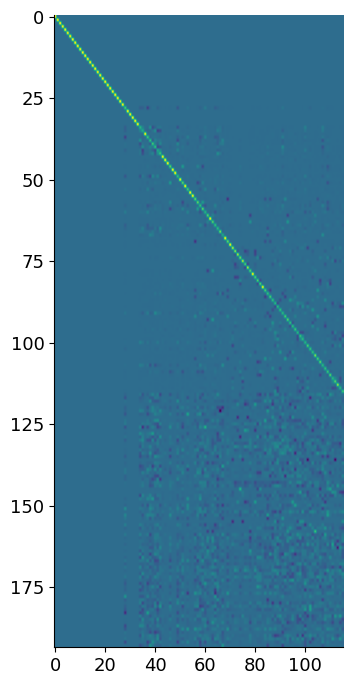

In [609]:
plt.ArrayPlot(anion_nitro.internal_coordinates.converter_options['redundant_transformation'], 
              image_size=(500*(108/len(anion_nitro.internals['specs'])), 500)
             )

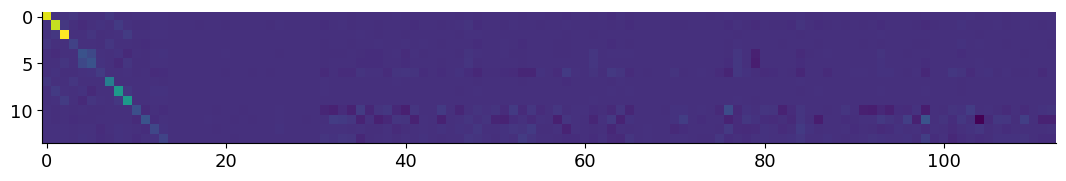

In [582]:
plt.ArrayPlot(internal_tensors[1][:14] * UnitsData.convert("Hartrees", "Wavenumbers"), aspect_ratio=14/108, image_size=(800, 1200))

In [ ]:
anion_nitro.animate_coordinate(100, extent=.5, steps=8)

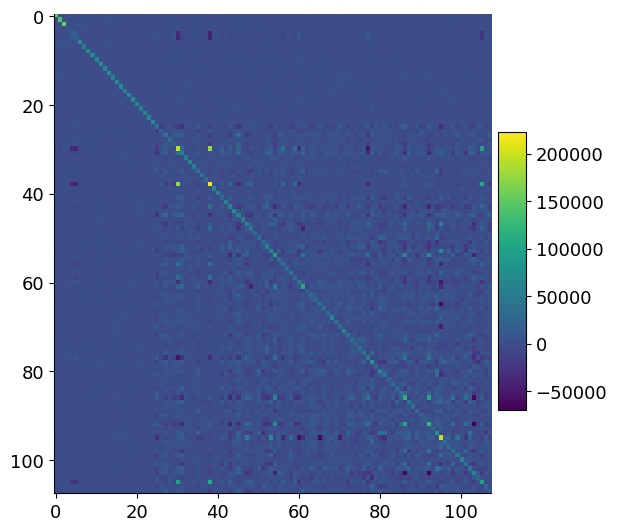

In [573]:
cart_conv = anion_nitro.get_cartesians_by_internals(2)
internal_tensors = nput.tensor_reexpand(cart_conv, [0, anion_nitro.potential_derivatives[1]])
plt.ArrayPlot(internal_tensors[1] * UnitsData.convert("Hartrees", "Wavenumbers"), colorbar=True)